<font color = Darkblue size = 11 face = bold> __Neural Style Transfer__
<br>
    
<font color = Darkblue size = 7 face = bold> __CS 319: Computer Vision__
<br>
    
<font color = Darkblue size = 6 face = bold> __Professor: Arman Chopikyan__
<br>   
    
<font color = Darkblue size = 6 face = bold> __Students: Yeva Avetisyan, Anush Aghinyan__

<font color = Darkblue size = 6 face = bold> Neural-Style, also known as Neural-Transfer, enables you to transform an image by combining the content of one image with the artistic style of another. 
<br>  

<font color = Darkblue size = 6 face = bold> The process involves three images: an input image, a content image, and a style image. The input image is adjusted to reflect the content of the content-image and the artistic style of the style-image.
<br> 

<font color = Darkblue size = 11 face = bold> __Paper Overview__
<br>
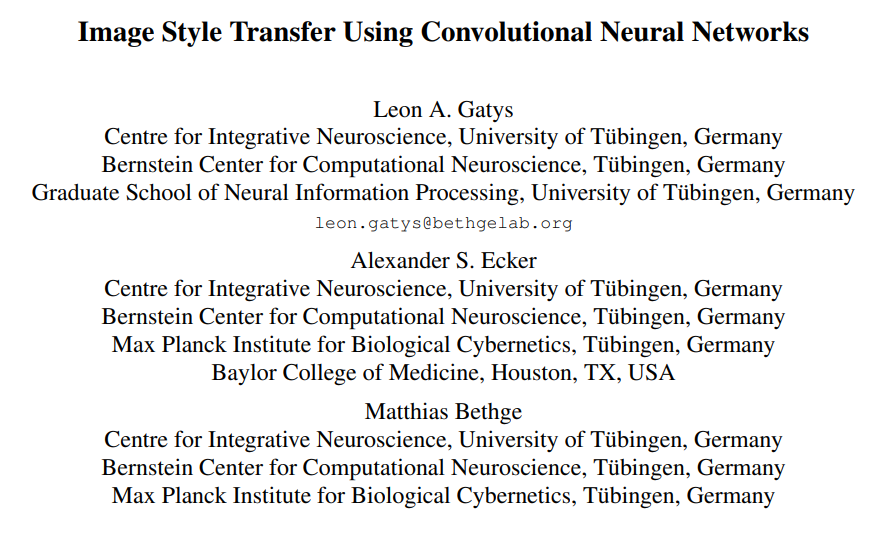

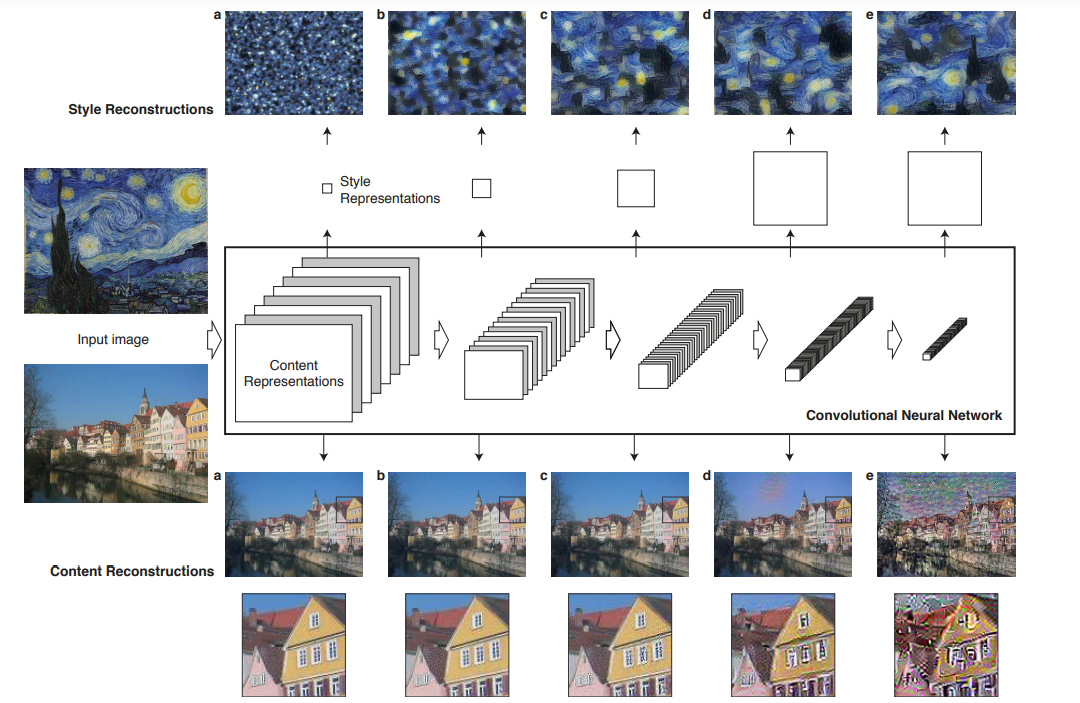

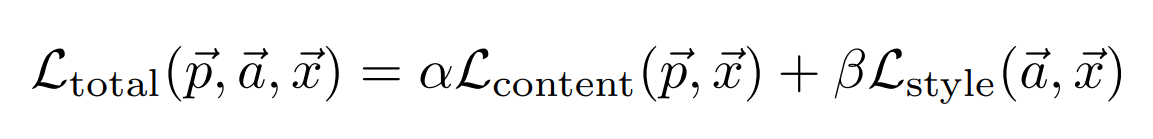

<font color = Darkblue size = 11 face = bold> __AUA__
<br>
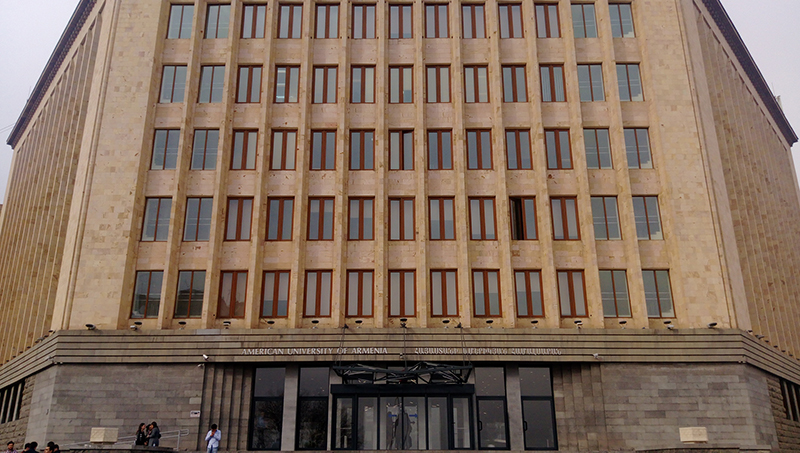

<font color = Darkblue size = 8 face = bold> __Wassily Kandinsky: Composition VII__
<br>
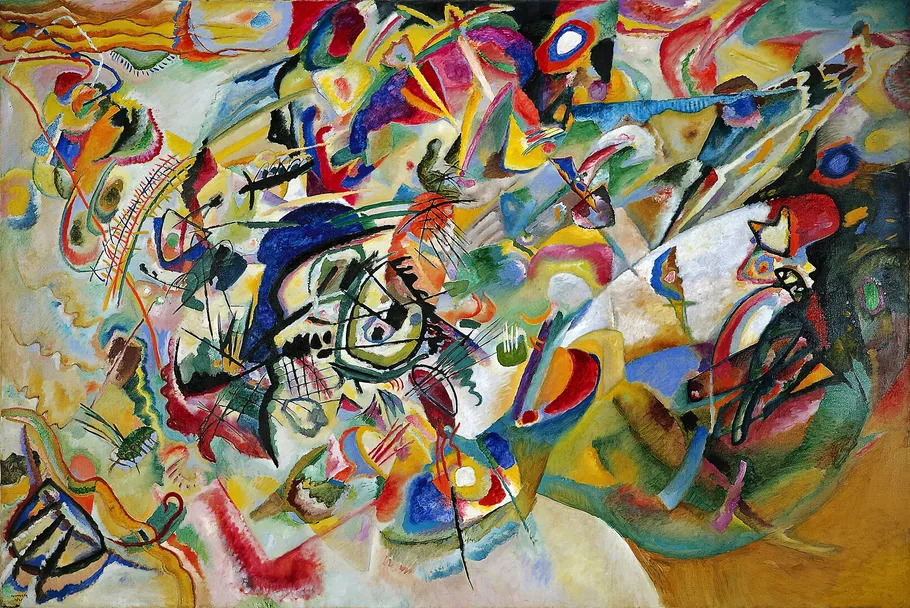

<font color = Darkblue size = 8 face = bold> __Vincent van Gogh: The Starry Night__
<br>
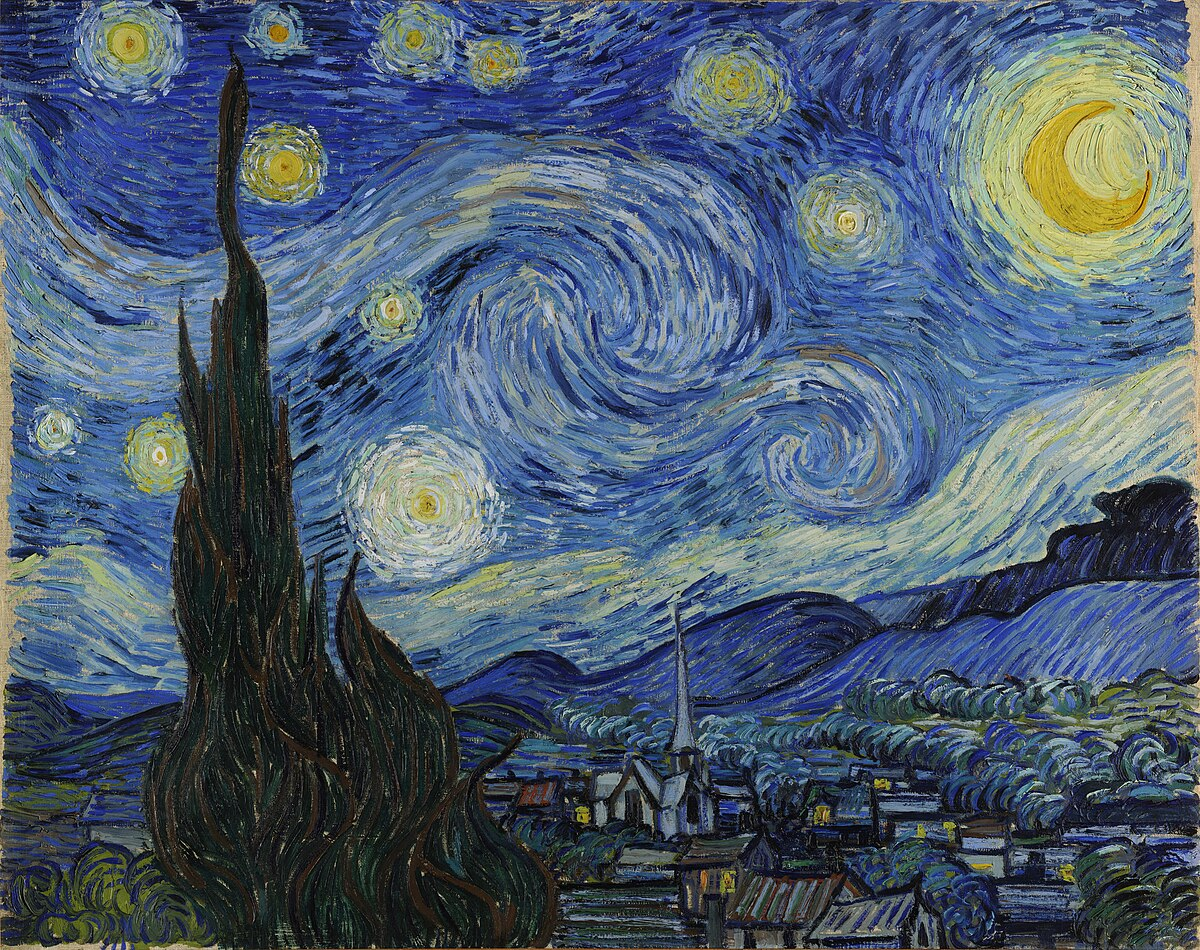

<font color = Darkblue size = 8 face = bold> __Kazimir Malevich: The Knifegrinder__
<br>
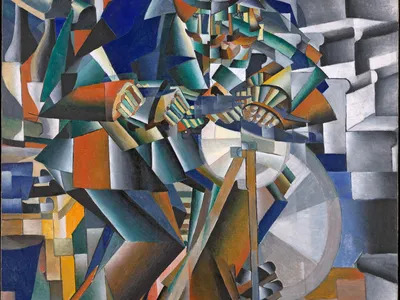

<font color = Darkblue size = 11 face = bold> __Neural Style Transfer__
<br>
<br>
<font color = Darkblue size = 11 face = bold> __using PyTorch__
<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
# Checking whether GPU is available or not
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

<font color = Darkblue size = 11 face = bold> __Loading the Images__
<br>

In [17]:
# Loading the Images

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

# desired size of the output image
desired_width = 512  # specify your desired width
loader = transforms.Compose([
    transforms.Resize((desired_width, desired_width)),  # set both dimensions to maintain aspect ratio
    transforms.CenterCrop((desired_width, desired_width)),  # center crop to the desired size
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    # apply the loader transformations
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img1 = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/kandinsky1.jpg")
content_img = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/aua.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

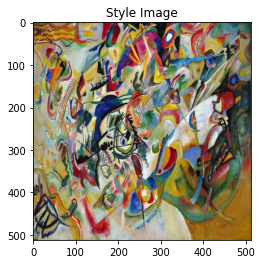

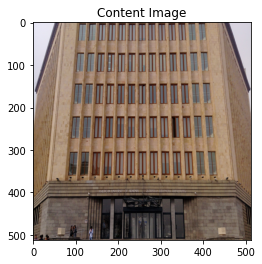

In [19]:
# Loading the Images

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img1, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

<font color = Darkblue size = 11 face = bold> __Helper Classes__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Content Loss__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Style Loss__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Importing the Model__

In [4]:
# Content Loss

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
# Style Loss

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [6]:
# Style Loss

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [7]:
# Importing the Model

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

<font color = Darkblue size = 8 face = bold> __- Input Image = Content Image__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Sequential Module__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Gradient Descent__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- A function that performs the neural transfer__
<br>
<br>
<font color = Darkblue size = 8 face = bold> __- Running the Algorithm__
<br>
<br>

# AUA + Composition VII

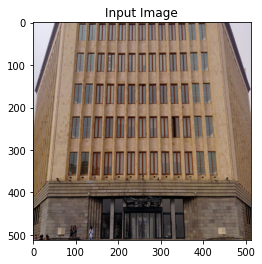

In [12]:
# Input Image

input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [20]:
# Sequential module that has content loss and style loss modules correctly inserted.

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img1, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img1).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [16]:
# Gradient Descent

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [21]:
# A function that performs the neural transfer.

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img1, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img1, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 123.376175 Content Loss: 31.761866

run [100]:
Style Loss : 31.299528 Content Loss: 31.792133

run [150]:
Style Loss : 12.050381 Content Loss: 29.977434

run [200]:
Style Loss : 6.107763 Content Loss: 27.943752

run [250]:
Style Loss : 4.081493 Content Loss: 26.072880

run [300]:
Style Loss : 3.111447 Content Loss: 24.817232



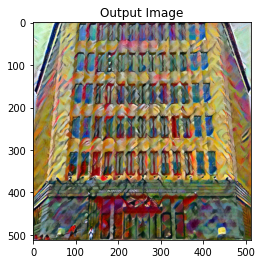

In [22]:
# Running the Algorithm

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [9]:
# Loading the Images

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

# desired size of the output image
desired_width = 512  # specify your desired width
loader = transforms.Compose([
    transforms.Resize((desired_width, desired_width)),  # set both dimensions to maintain aspect ratio
    transforms.CenterCrop((desired_width, desired_width)),  # center crop to the desired size
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    # apply the loader transformations
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/starrynight.jpg")
content_img = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/aua.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

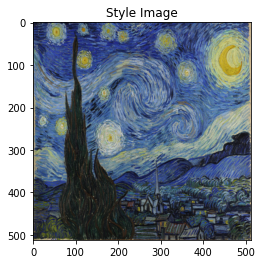

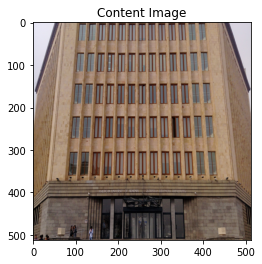

In [10]:
# Loading the Images

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [11]:
# Sequential module that has content loss and style loss modules correctly inserted.

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
# Gradient Descent

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
# A function that performs the neural transfer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\User\anaconda3\lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 69.701187 Content Loss: 24.902500

run [100]:
Style Loss : 13.786210 Content Loss: 22.109722

run [150]:
Style Loss : 7.641928 Content Loss: 18.958738

run [200]:
Style Loss : 4.945779 Content Loss: 17.115257

run [250]:
Style Loss : 3.516594 Content Loss: 16.063164

run [300]:
Style Loss : 2.587086 Content Loss: 15.297207



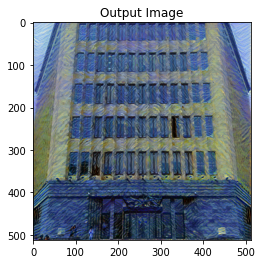

In [15]:
# Running the Algorithm

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# AUA + The Starry Night

<font color = Darkblue size = 8 face = bold> __AUA + Composition VII__
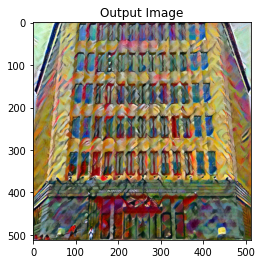

<font color = Darkblue size = 8 face = bold> __AUA + The Starry Night__
<br>
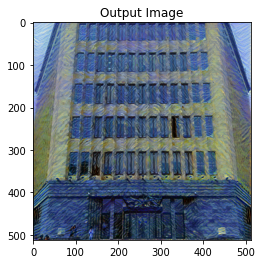

<font color = Darkblue size = 8 face = bold> __AUA + The Knifegrinder__
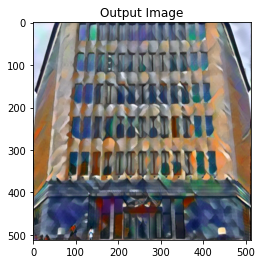


<font color = Darkblue size = 11 face = bold> __Thank you for your attention!__
<br>

# AUA + The Knifegrinder

In [23]:
style_img2 = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/malevich.jpg")
content_img = image_loader("C:/Users/User/Desktop/NST-PyTorch/images/aua.jpg")

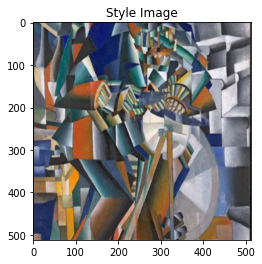

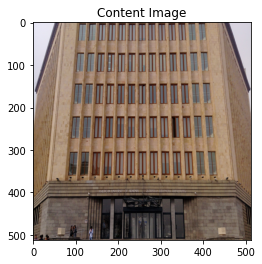

In [24]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img2, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [25]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img2).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [26]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img2, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img2, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 25.502544 Content Loss: 16.793125

run [100]:
Style Loss : 7.228342 Content Loss: 14.551544

run [150]:
Style Loss : 4.130824 Content Loss: 12.941077

run [200]:
Style Loss : 2.741427 Content Loss: 12.088027

run [250]:
Style Loss : 2.009907 Content Loss: 11.560205

run [300]:
Style Loss : 1.608355 Content Loss: 11.186228



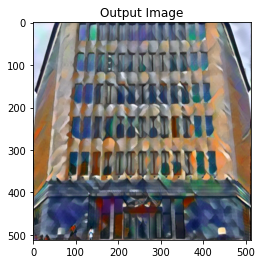

In [27]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img2, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# References
### https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
### https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf